In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import re
import inflect # the data has plurals such as 3/4th sleeve and sleeves, so inflect deals with those
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [2]:
df = pd.read_csv('dress_rental_prices.csv',index_col=0)
df.head()

,ID,Name,Brand,Colour,Catagories,Price
0,74416,Runway stripe dress,Stella McCartney,beige,dresses,111
1,73815,Reformation Kourtney Dress,Reformation,beige,dresses,50
2,73801,Ivory Viola bridal dress,Ghost,beige,dresses,75
3,73718,Pasu Dress - Rhino Tusk,Coucoo,beige,dresses,37
4,73605,Ellen,RIXO,beige,dresses,47


In [3]:
df = df.drop(['ID','Name'],axis=1)
df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [4]:
df.shape

(29997, 4)

In [5]:
df.isna().sum()

Brand           0
Colour          0
Catagories    114
Price           0
dtype: int64

In [6]:
df = df.dropna()
df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [7]:
df.duplicated().sum()

7892

In [8]:
df = df.drop_duplicates()
df

,Brand,Colour,Catagories,Price
0,Stella McCartney,beige,dresses,111
1,Reformation,beige,dresses,50
2,Ghost,beige,dresses,75
3,Coucoo,beige,dresses,37
4,RIXO,beige,dresses,47
...,...,...,...,...
29992,Victoria Beckham,yellow,"dresses, Smart, midi, Short Sleeve, Pencil, Mo...",102
29993,Faithfull The Brand,yellow,"dresses, Floral, Polka Dot, Loose, Smart Casua...",43
29994,Solace London,yellow,"dresses, Vinyl-PVC-Synthetics, Smart, Formal, ...",75
29995,Rebecca Vallance,yellow,"dresses, Cotton-Jersey, Tie-Front, Skinny-Fit,...",42


In [9]:
df['Colour'].value_counts()

black      3253
multi      2716
pink       2562
blue       2378
green      1943
white      1787
red        1623
beige       960
yellow      811
navy        669
purple      660
orange      625
brown       488
cream       485
gold        422
silver      343
grey        111
copper      111
tan          29
phantom      15
Name: Colour, dtype: int64

In [10]:
df['tokens'] = df['Catagories'].str.split(', ')
df['tokens']
 
all_tokens = [token for sublist in df['tokens'].tolist() for token in sublist]
unique_tokens = list(set(all_tokens))
len(unique_tokens)

C:\Users\Anish\AppData\Local\Temp\ipykernel_11972\2158239739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['Catagories'].str.split(', ')


296

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
 
stop_words = set(stopwords.words('english'))
p = inflect.engine() 
 
def clean_text(text):
    text = re.sub(r'[-/]', ' ', text)     # Remove hyphens and slashes
    text = re.sub(r'[^\w\s]', '', text.lower())     # Remove punctuation and lowercase the text
    tokens = word_tokenize(text)     # Tokenize and remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Convert plural words to singular
    tokens = [p.singular_noun(word) if p.singular_noun(word) else word for word in tokens]
    return ''.join(tokens)
 
def clean_dataframe_column(df, column):
    df[column] = df[column].apply(lambda x: ', '.join([clean_text(token) for token in x.split(', ')]))
    return df
 
df = clean_dataframe_column(df, 'Catagories')
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Anish\AppData\Local\Temp\ipykernel_11972\250584837.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: ', '.join([clean_text(token) for token in x.split(', ')]))


,Brand,Colour,Catagories,Price,tokens
0,Stella McCartney,beige,dress,111,[dresses]
1,Reformation,beige,dress,50,[dresses]
2,Ghost,beige,dress,75,[dresses]
3,Coucoo,beige,dress,37,[dresses]
4,RIXO,beige,dress,47,[dresses]


In [12]:
df = df.drop(['tokens'],axis=1)

In [13]:
ohe = df['Catagories'].str.get_dummies(sep=',') 
 
df = pd.concat([df,ohe],axis=1)

df_new = pd.get_dummies(df, columns=['Brand','Colour']) 
df = pd.concat([df,df_new],axis=1)
df.head()

,Brand,Colour,Catagories,Price,,34sleeve,abstract,animalprint,applique,apron,...,Colour_navy,Colour_orange,Colour_phantom,Colour_pink,Colour_purple,Colour_red,Colour_silver,Colour_tan,Colour_white,Colour_yellow
0,Stella McCartney,beige,dress,111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Reformation,beige,dress,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ghost,beige,dress,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Coucoo,beige,dress,37,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RIXO,beige,dress,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df = df.drop(['Brand','Catagories','Colour'],axis=1) 
df

,Price,,34sleeve,abstract,animalprint,applique,apron,asymmetric,autumn,aztec,...,Colour_navy,Colour_orange,Colour_phantom,Colour_pink,Colour_purple,Colour_red,Colour_silver,Colour_tan,Colour_white,Colour_yellow
0,111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,102,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29993,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29994,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29995,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
X = df.drop('Price', axis=1)
y = df['Price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
pca = PCA(n_components=0.95) # 1500+ columns, selecting only necessary components
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [18]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='tanh'))

model.add(Dense(1))

C:\Users\Anish\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5933.6235 - val_loss: 4820.5723
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4995.6089 - val_loss: 4300.6235
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4605.5352 - val_loss: 3846.9966
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4003.8486 - val_loss: 3447.0425
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4004.5107 - val_loss: 3097.3496
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3235.9836 - val_loss: 2790.9548
Epoch 7/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2969.1165 - val_loss: 2526.3384
Epoch 8/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2690.1086 - val_loss: 2301.0398
Epoch 9/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2706.9573 - val_loss: 2113.3616
Epoch 10/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2436.7783 - val_loss: 1959.7667
Epoch 11/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2236.4338 - val_lo

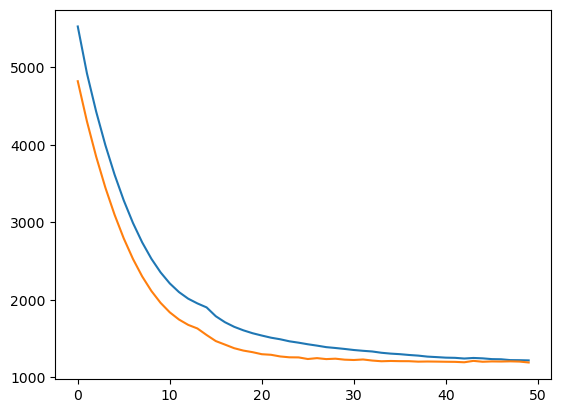

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])